In [1]:
import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories
from src.tools import load_dataset

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
batch_size = 16
IMG_SIZE = 32
IMG_CHANNELS = 3
ZC = 1
TIME_DIM = 128
UNET_BASE_FACTOR = 48
N_STEPS = 10
Z_STD = 1.0
GAMMA = 0.0

lr = 1e-4

G_ITERS = 5
D_ITERS = 1
f_ITERS = 10
MAX_STEPS = 50000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
sampler3, test_sampler3 = load_dataset('MNIST-colored_3', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
sampler2, test_sampler2 = load_dataset('MNIST-colored_2', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
X_sampler = sampler3
Y_sampler = sampler2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


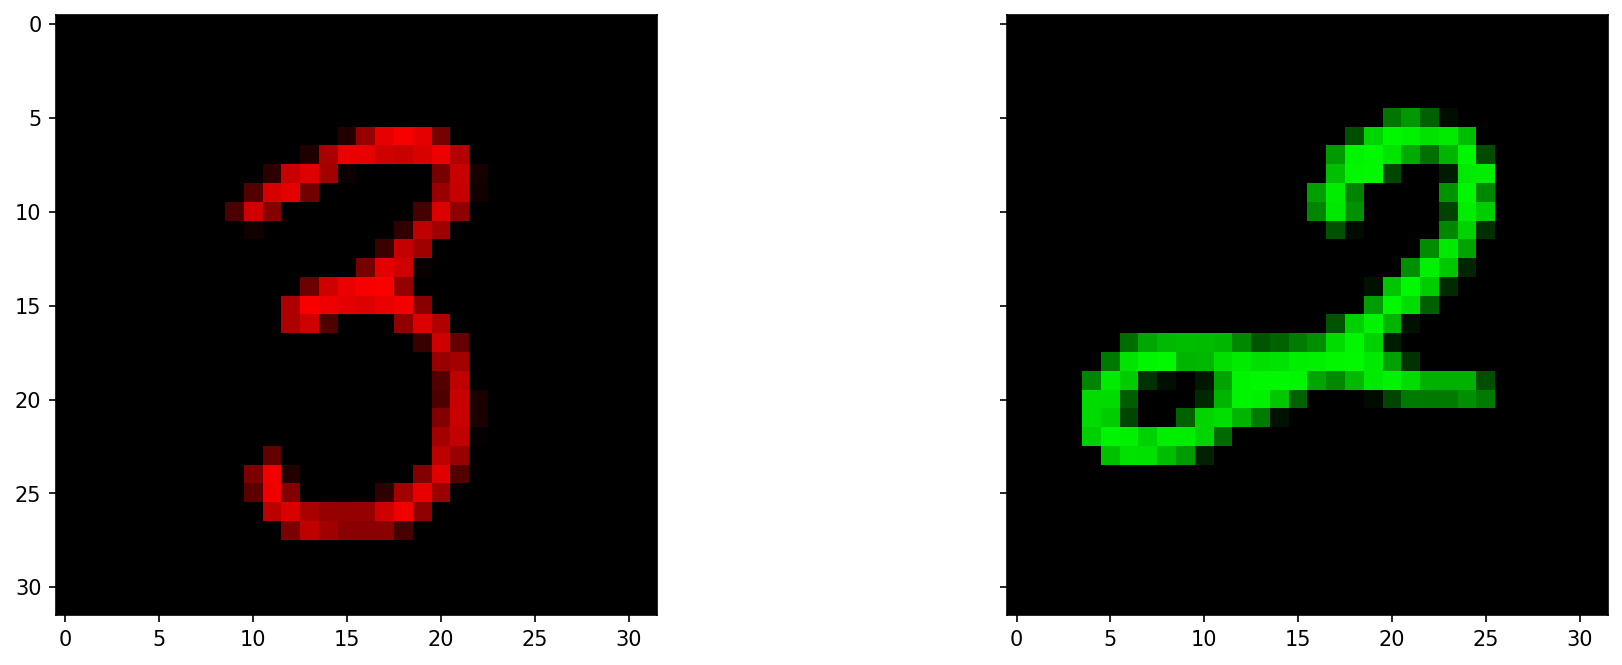

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True)
x0 = X_sampler.sample(1)
x1 = Y_sampler.sample(1)
axes[0].imshow(x0[0].cpu().detach().permute(1, 2, 0))
axes[1].imshow(x1[0].cpu().detach().permute(1, 2, 0))
plt.show()

In [6]:
# lr = 1e-4
# n_steps = 100
# GAMMA = 0.0
G_ITERS = 5
D_ITERS = 1
f_ITERS = 10
MAX_STEPS = 50000


# ZC = 1
# Z_STD = 1.0

In [7]:
from MNIST_models.cunet import CUNet
from MNIST_models.resnet import ResNet_D
from MNIST_models.unet import UNet
from MNIST_models.enot import SDE

In [8]:
D = ResNet_D(IMG_SIZE, nc=IMG_CHANNELS).to(device)
G = UNet(IMG_CHANNELS+ZC, IMG_CHANNELS, base_factor=UNET_BASE_FACTOR).to(device)
f = CUNet(IMG_CHANNELS, IMG_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR).to(device)
sde = SDE(shift_model=f, n_steps=N_STEPS, time_dim=TIME_DIM).to(device)

sde_opt = Adam(sde.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)
    
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))
print('G params:', np.sum([np.prod(p.shape) for p in G.parameters()]))
print('sde params:', np.sum([np.prod(p.shape) for p in sde.parameters()]))

D params: 13494209
G params: 9716259
sde params: 9934611


In [9]:
x0 = X_sampler.sample(batch_size)
Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE)).to(device) * Z_STD
xN = G(torch.cat([x0, Z], axis = 1))


t = (torch.rand(batch_size)*0.99).to(device)
t_emb = sde.time(t)[:, :, None, None]
t = t[:, None, None, None]
xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)


f_loss = ((sde.shift_model(xt, t_emb) - (xN - xt)/(1-t)) ** 2).mean()

xN = sde(x0)

In [65]:
def plot_images(T, sampler, n_x, n_samples, epsilon, inds = (0, 1, 2, 3)):
    assert len(inds) == 4
    X = torch.stack([sampler.loader.dataset[ind][0] for ind in inds], dim=0)
    
    T_X = torch.stack([T(X, epsilon) for i in range(n_samples)], dim=1)
    T_X = T_X.detach().permute(0,1,3,4,2).mul(0.5).add(0.5).numpy().clip(0,1)
    X = X.permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
    
    fig, axes = plt.subplots(n_x, n_samples, figsize=(2.75, 3), dpi=450)
    
    for i in range(n_x):
        for j in range(0, n_samples):
            ax = axes[i][j]
            ax.imshow(T_X[i][j])
            
            ax.get_xaxis().set_visible(False)
            ax.set_yticks([])
            
            if i == 0:
                ax.set_title(r"$T_f(X)$")
            
    fig.tight_layout(pad=0.01)

    
def plot_trajectories(models, gammas, sampler, n_x):
    n_samples = 10
    fig, axes = plt.subplots(n_x, n_samples+1, figsize=(6.7, 2), dpi=400)
    
    X = sampler.sample(1)
    
    for i in range(n_x):
        T = models[i]
    
        T_X = torch.stack(T(X, gammas[i], traj=True)[1], dim=1)[:, 1:]
        T_X = T_X.detach().permute(0,1,3,4,2).mul(0.5).add(0.5).numpy().clip(0,1)
        X_img = X.permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
        
        ax = axes[i][0]
        ax.imshow(X_img[0])
        
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(r"$X \sim \mathbb{P}_0$")
        
        ax.set_ylabel(fr"$\epsilon=${gammas[i]}")
        
        for j in range(0, n_samples):
            ax = axes[i][j+1]
            ax.imshow(T_X[0][j])
            
            ax.get_xaxis().set_visible(False)
            ax.set_yticks([])
            
            if i == 0:
                ax.set_title(fr"t={round(0.1*(j+1), 1)}")
            
    fig.tight_layout(pad=0.001)


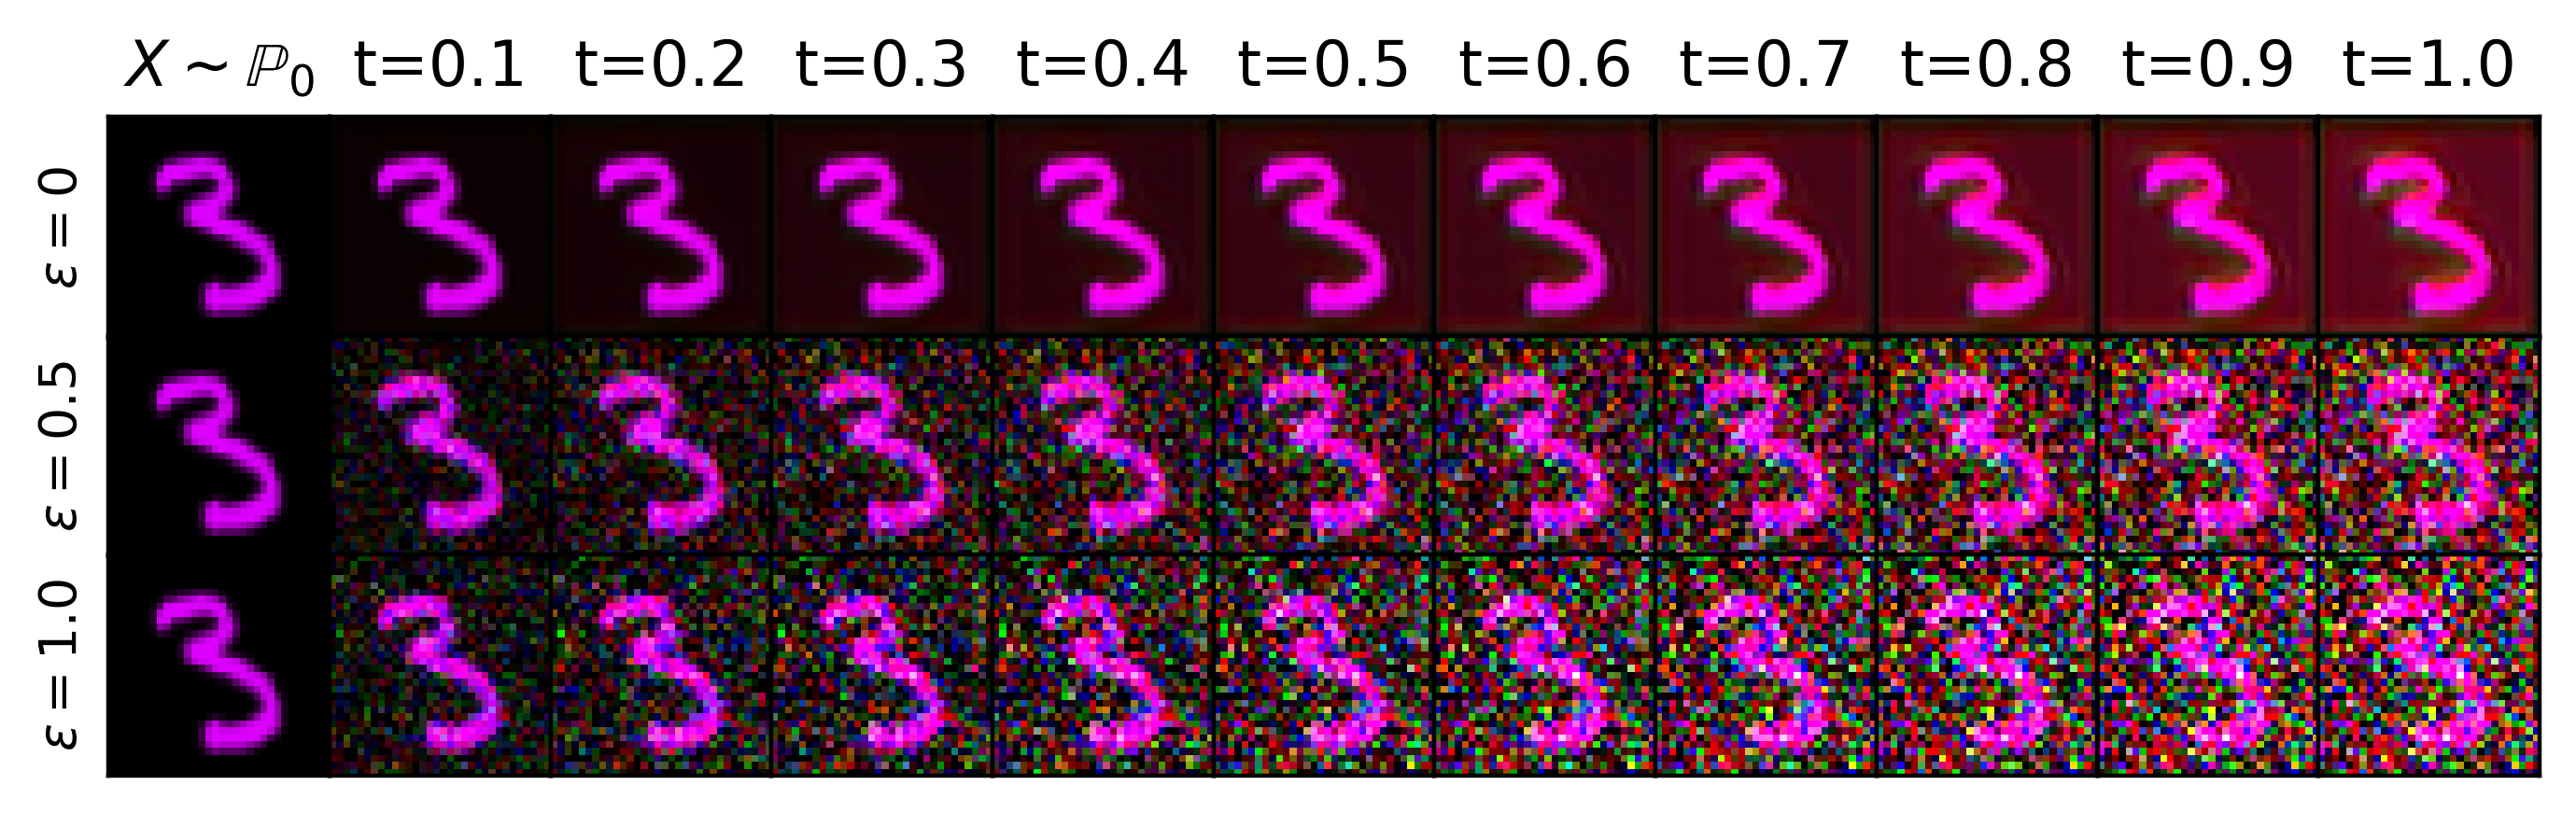

In [66]:
models = [sde, sde, sde]
gammas = [0, 0.5, 1.0]

plot_trajectories(models, gammas, X_sampler, 3)

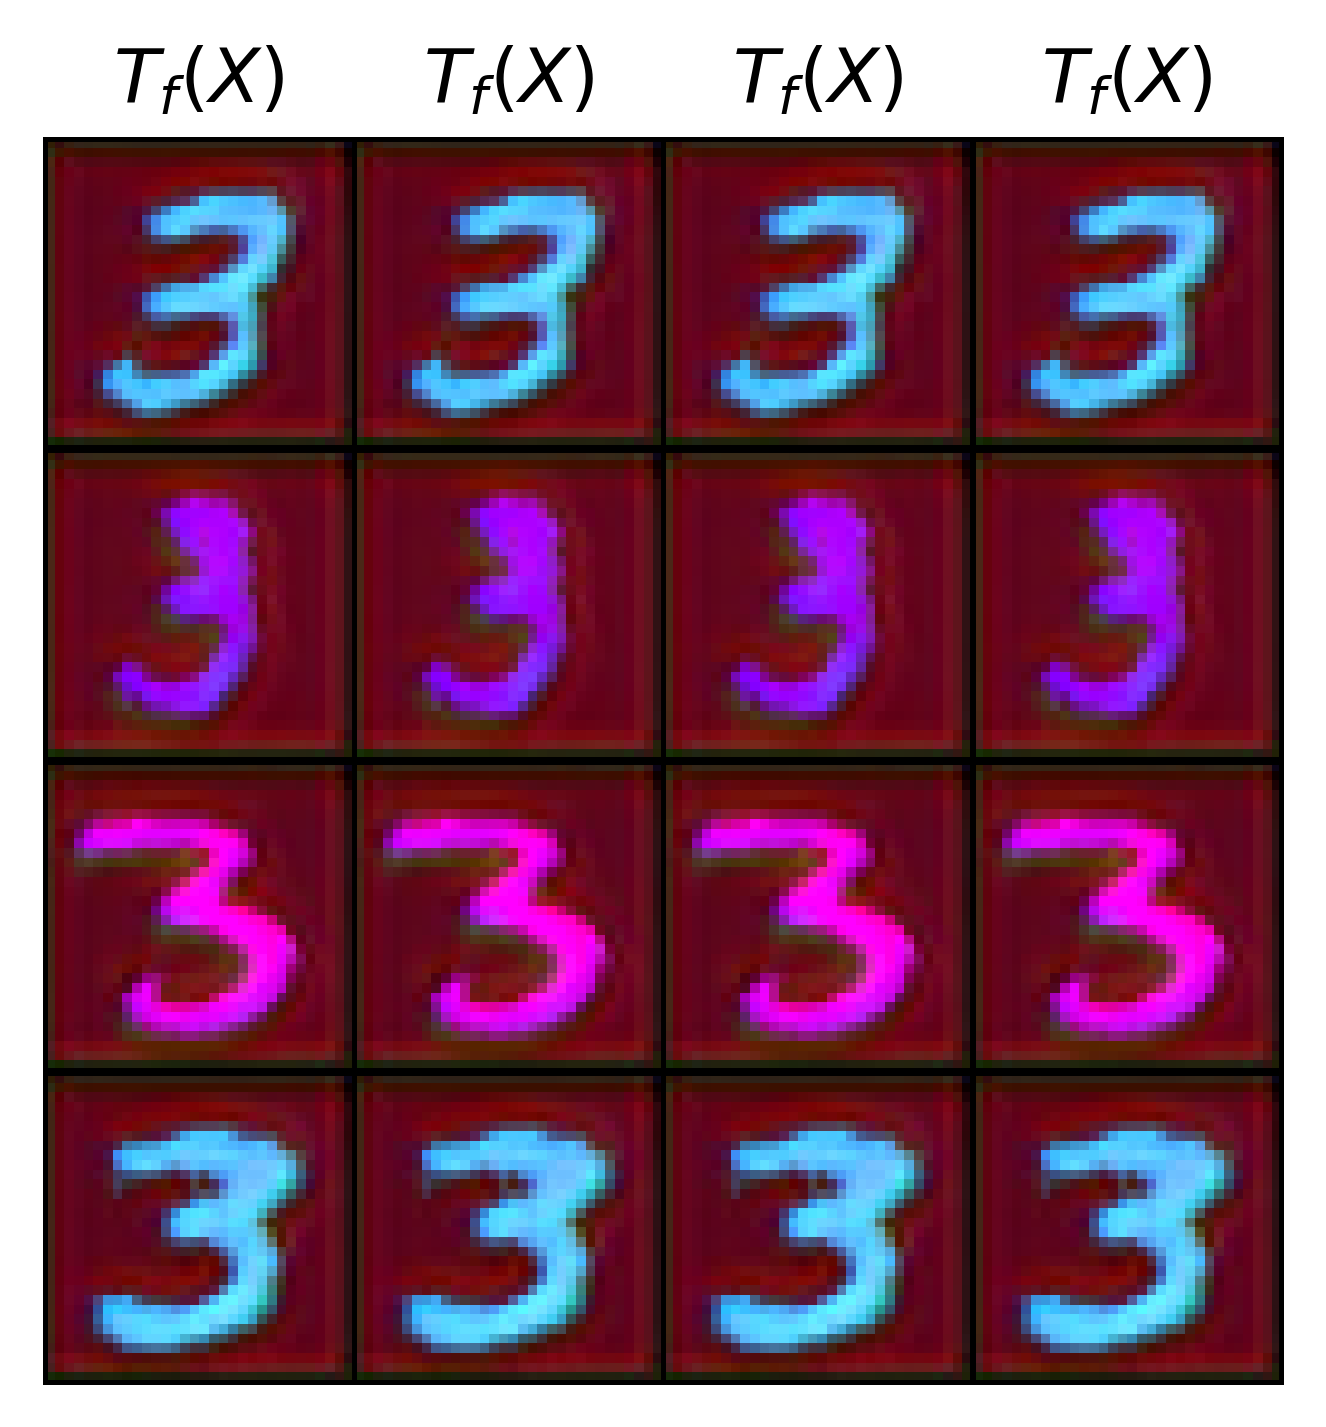

In [67]:
plot_images(sde, X_sampler, 4, 4, 0)

In [ ]:
def trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        # for G_iter in range(G_ITERS):

            # for f_iter in range(f_ITERS):
            #     print(f_iter)
            #     x0 = X_sampler.sample(batch_size)
            #     Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE)).to(device) * Z_STD
            #     xN = G(torch.cat([x0, Z], axis = 1))
                
            #     t = (torch.rand(batch_size)*0.99).to(device)
            #     t_emb = sde.time(t)[:, :, None, None]
            #     t = t[:, None, None, None]
            #     xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
            #     f_loss = ((sde.shift_model(xt, t_emb) - (xN - xt)/(1-t)) ** 2).mean()
            #     sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()

            # x0 = X_sampler.sample(batch_size)
            # Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE)).to(device) * Z_STD
            # xN = G(torch.cat([x0, Z], axis = 1))

            # t = (torch.rand(batch_size)*0.99).to(device)
            # t_emb = sde.time(t)[:, :, None, None]
            # t = t[:, None, None, None]
            # xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            # f_x_t = sde.shift_model(xt, t_emb)
            # E = (xN - xt)/(1-t)

            # loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)*2
            # loss2 = - D(xN).mean()

            # G_loss = loss1 + loss2
            
            # G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        
        # plotter 1
        if step % 100 == 0:
            clear_output(wait=True)
            
            # fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
            # plt.show()
            
            
        # for D_iter in range(D_ITERS):    
        #     x0 = X_sampler.sample(batch_size)
        #     x1 = Y_sampler.sample(batch_size)
        #     Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE)).to(device) * Z_STD
        #     xN = G(torch.cat([x0, Z], axis = 1))
        #     D_loss = (- D(x1) + D(xN)).mean()
        #     D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

In [16]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt)

  0%|          | 0/50000 [00:00<?, ?it/s]


NameError: name 'plot_n_samples' is not defined

In [10]:
x0 = X_sampler.sample(batch_size)
Z = torch.randn((batch_size, ZC, IMG_SIZE, IMG_SIZE)).to(device) * Z_STD
xN = G(torch.cat([x0, Z], axis = 1))


t = (torch.rand(batch_size)*0.99).to(device)
t_emb = sde.time(t)[:, :, None, None]
t = t[:, None, None, None]
xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)


f_loss = ((sde.shift_model(xt, t_emb) - (xN - xt)/(1-t)) ** 2).mean()

xN = sde(x0)

In [ ]:
# sde_opt = Adam(sde.parameters(), lr=lr)
# G_opt = Adam(G.parameters(), lr=lr)
# D_opt = Adam(D.parameters(), lr=lr)

In [11]:
# stats = trainGD(X_sampler, Y_sampler, sde, sde_opt, G, G_opt, D, D_opt, plot_n_samples=1000)

In [12]:
# torch.save(G, 'G_MNIST.pt')
# torch.save(D, 'D_MNIST.pt')